# Preventive Health

**Our Data**

* Clinical and financial data of patients hospitalised for a certain (X) condition
* Per row per patient’s total bill per year
* 3,314 rows 
* 3,000 unique patients
* 5 year data (2011 - 2015)

**Variables**

* Number of encounter per year (continuous)
* Age (continuous)
* Age (<55, >55) (categorical)
* BMI (continuous)
* BMI Risk Level (categorical)
* Number of Medical History (continuous)
* Medical History 1 through 7 (binary)

Total number of data = 3,312 (per row per admission)

In [1]:
# import packages

import psycopg2
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Processing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# display options

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',200)

In [2]:
# connect to database

engine = psycopg2.connect("dbname=holmusk user=joannasyeow")
f = open("codes/sql_pt_2.sql", "r")
sql = f.read()
df = pd.read_sql(sql, con=engine)

In [3]:
# have a quick look at our data

df.head()

,id_,patient_id,no_enc,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,age_at_yr,age_grp,gender_c,race_c,resident_status_c,avg_bmi,bmi_risk,bmi_high,indian,chinese,malay,other,sg,pr,foreigner,tot_bill_yr
0,8461069832,00225710a878eff524a1d13be817e8e2,1,0,0,0,0,0,0,1,1,31,0,1,2,0,27.85,4,1,0,1,0,0,1,0,0,5190.57
1,5621737529,0029d90eb654699c18001c17efb0f129,1,0,1,0,0,0,1,0,2,69,1,1,2,0,34.80,4,1,0,1,0,0,1,0,0,22601.50
2,9921582850,0040333abd68527ecb53e1db9073f52e,1,0,1,0,0,0,0,1,2,41,0,0,1,0,26.87,3,0,1,0,0,0,1,0,0,17447.18
3,7239419545,00473b58e3dc8ae37b3cb34069705083,1,1,0,0,0,0,0,0,1,38,0,1,2,0,31.68,4,1,0,1,0,0,1,0,0,15285.88
4,9476531069,0078662d1d983dde68ea057c42d5b5cf,1,0,1,0,0,0,1,0,2,70,1,0,3,2,24.96,3,0,0,0,1,0,0,0,1,73477.87


In [4]:
df.describe()

,id_,no_enc,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,age_at_yr,age_grp,gender_c,race_c,resident_status_c,avg_bmi,bmi_risk,bmi_high,indian,chinese,malay,other,sg,pr,foreigner,tot_bill_yr
count,3.314000e+03,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000
mean,8.028419e+09,1.025951,0.173205,0.296319,0.138202,0.053108,0.059747,0.259505,0.259807,1.239891,52.491249,0.414906,0.501207,2.216657,0.246530,28.948401,3.554617,0.636391,0.099276,0.638503,0.208509,0.053712,0.800845,0.151780,0.047375,22426.325356
std,1.599729e+09,0.160899,0.378481,0.456702,0.345164,0.224283,0.237052,0.438429,0.438595,0.988355,14.681201,0.492780,0.500074,0.689808,0.529705,4.128680,0.643201,0.481111,0.299077,0.480507,0.406304,0.225482,0.399425,0.358862,0.212471,11013.200725
min,1.350319e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,1.000000,0.000000,17.510000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2946.100000
25%,7.125563e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,0.000000,2.000000,0.000000,26.152500,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,14969.707500
50%,8.395612e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,51.000000,0.000000,1.000000,2.000000,0.000000,28.940000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20475.510000
75%,9.304884e+09,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,65.000000,1.000000,1.000000,3.000000,0.000000,31.717500,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,27254.155000
max,9.999633e+09,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,85.000000,1.000000,1.000000,4.000000,2.000000,46.680000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98723.850000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3314 entries, 0 to 3313
Data columns (total 27 columns):
id_                    3314 non-null int64
patient_id             3314 non-null object
no_enc                 3314 non-null int64
medical_history_1      3314 non-null int64
medical_history_2_c    3314 non-null int64
medical_history_3_c    3314 non-null int64
medical_history_4      3314 non-null int64
medical_history_5_c    3314 non-null int64
medical_history_6      3314 non-null int64
medical_history_7      3314 non-null int64
no_med_hist            3314 non-null int64
age_at_yr              3314 non-null int64
age_grp                3314 non-null int64
gender_c               3314 non-null int64
race_c                 3314 non-null int64
resident_status_c      3314 non-null int64
avg_bmi                3314 non-null float64
bmi_risk               3314 non-null int64
bmi_high               3314 non-null int64
indian                 3314 non-null int64
chinese                3314 no

In [6]:
# check for duplicated rows

len(df.loc[df.duplicated(), :])

0

Great ! Seems like data is all cleaned up from SQL end.

# Target Variable

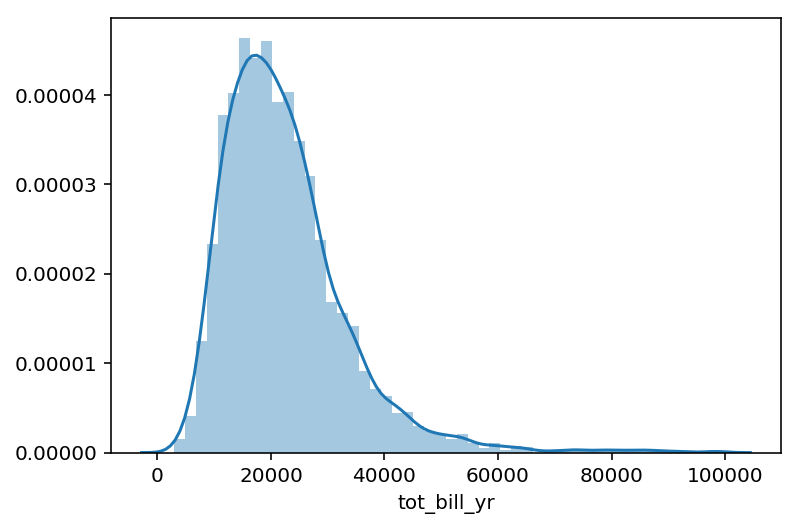

p-value (Sharpiro-Wilk Test):  4.203895392974451e-45


In [7]:
# Sharpiro-Wilk Test for Normality

sns.distplot(df['tot_bill_yr'])
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(df['tot_bill_yr'])[1])

Similarly, I will be applying log transformation for the target variable

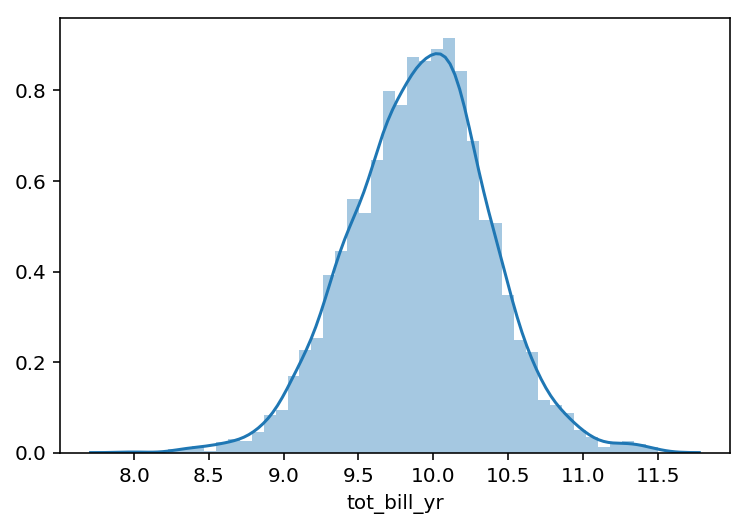

p-value (Sharpiro-Wilk Test):  0.000136852846480906


In [8]:
# Sharpiro-Wilk Test for Normality

sns.distplot(np.log(df['tot_bill_yr']))
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(np.log(df['tot_bill_yr']))[1])


Now that looks better !

In [9]:
# create new target variable
df['log_bill'] = np.log(df['tot_bill_yr'])

# Medical History Analysis

In [10]:
hist_col = ['no_med_hist','medical_history_1','medical_history_2_c','medical_history_3_c','medical_history_4','medical_history_5_c','medical_history_6','medical_history_7']

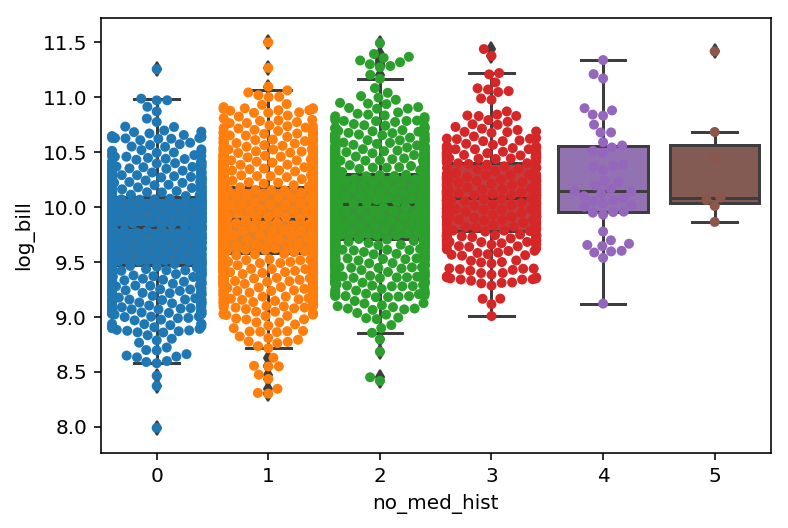

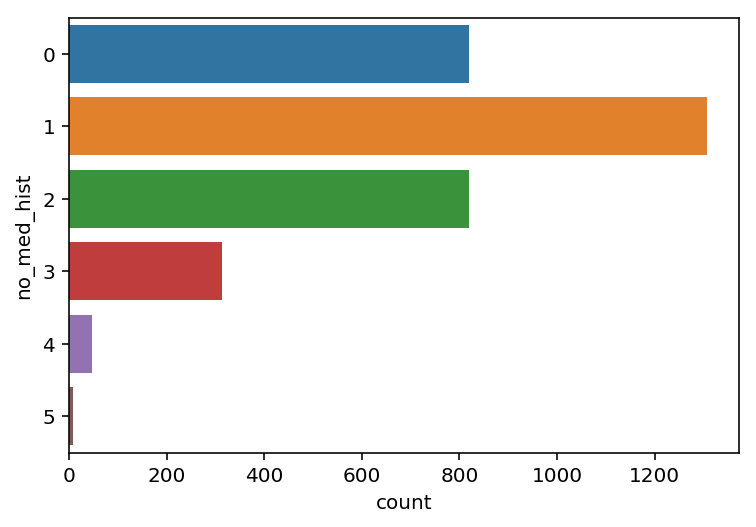


Value Count:
no_med_hist
0     795
1    1258
2     800
3     310
4      47
5       7
Name: patient_id, dtype: int64

Mean Total Bills:
no_med_hist
0    19497.499451
1    21463.517230
2    24696.981524
3    26532.163003
4    31191.712766
5    36853.327143
Name: tot_bill_yr, dtype: float64



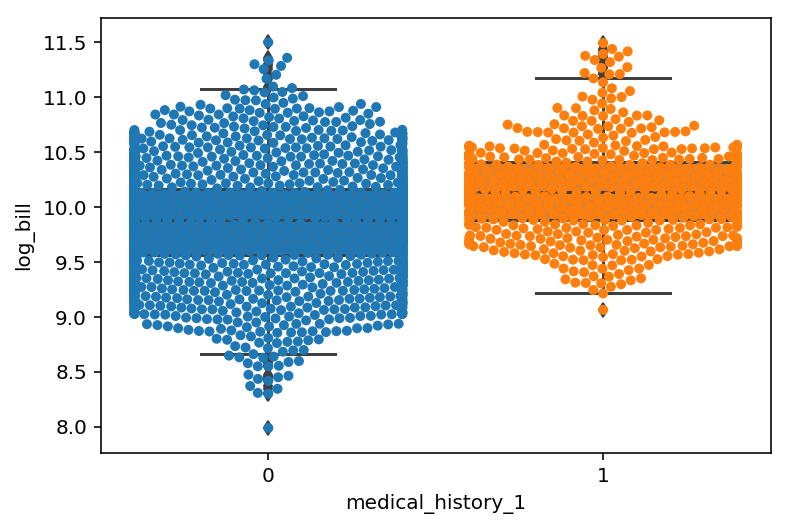

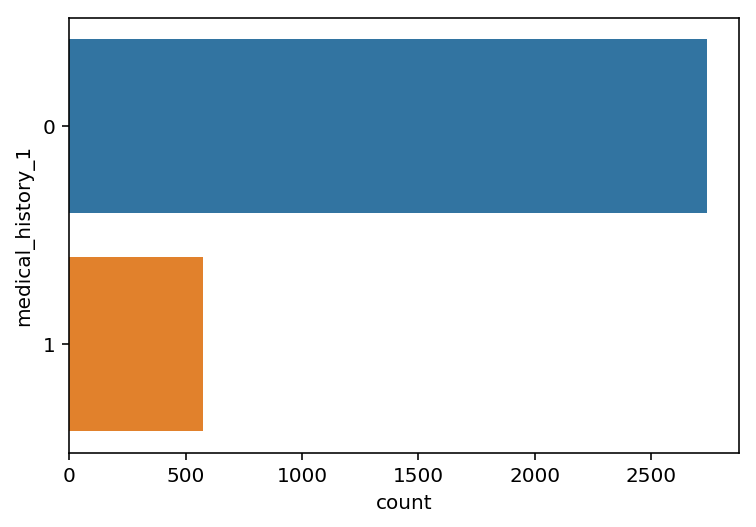


Value Count:
medical_history_1
0    2525
1     562
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    21248.400847
1    28049.170575
Name: tot_bill_yr, dtype: float64



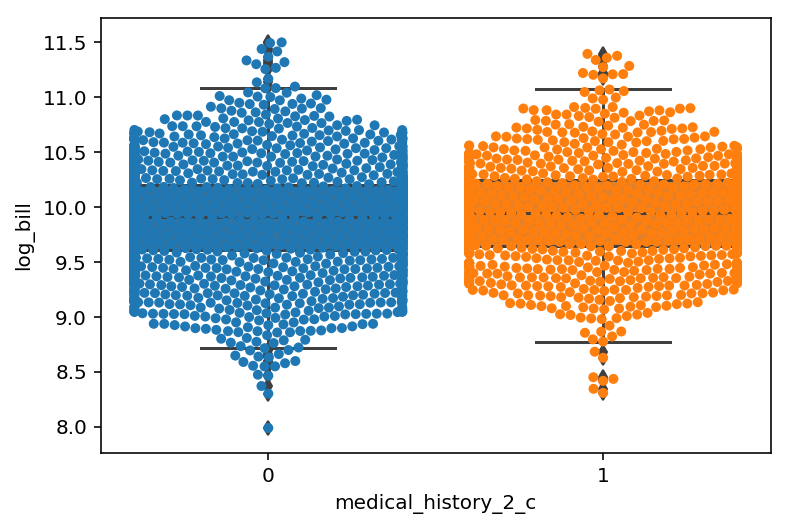

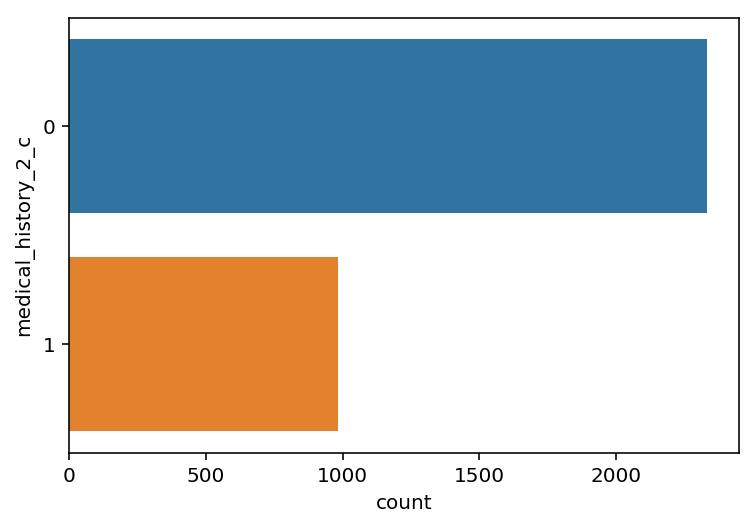


Value Count:
medical_history_2_c
0    2176
1     953
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    22026.923203
1    23374.803788
Name: tot_bill_yr, dtype: float64



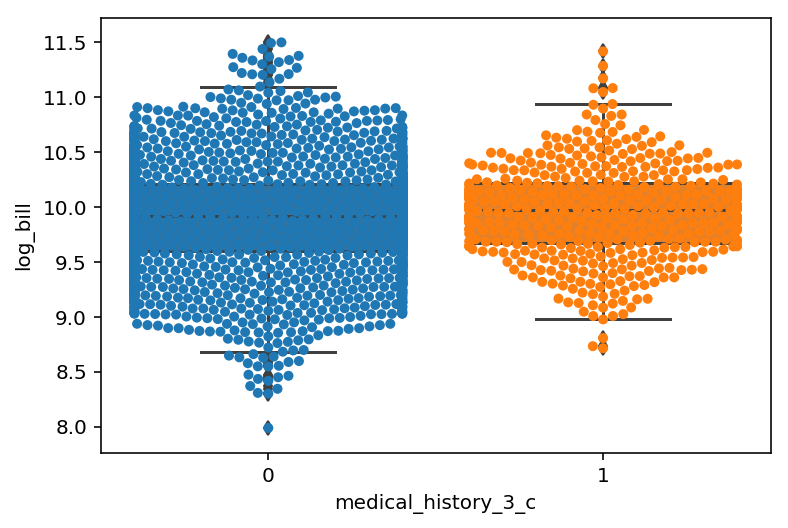

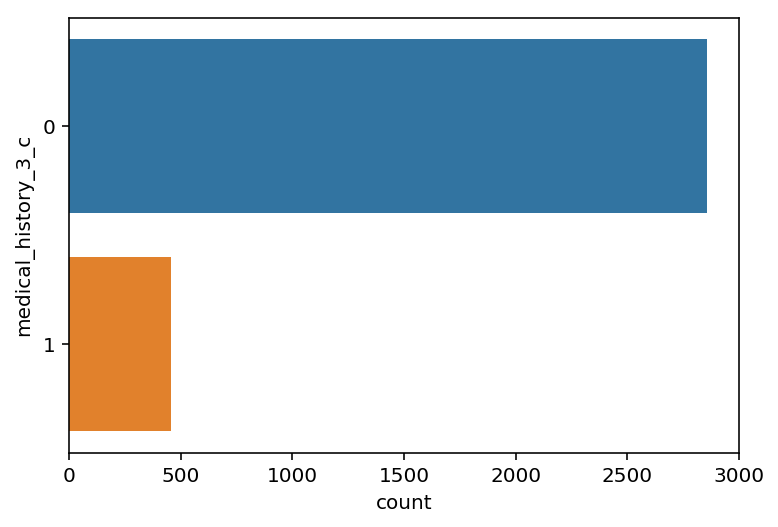


Value Count:
medical_history_3_c
0    2621
1     455
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_3_c
0    22308.178722
1    23163.065066
Name: tot_bill_yr, dtype: float64



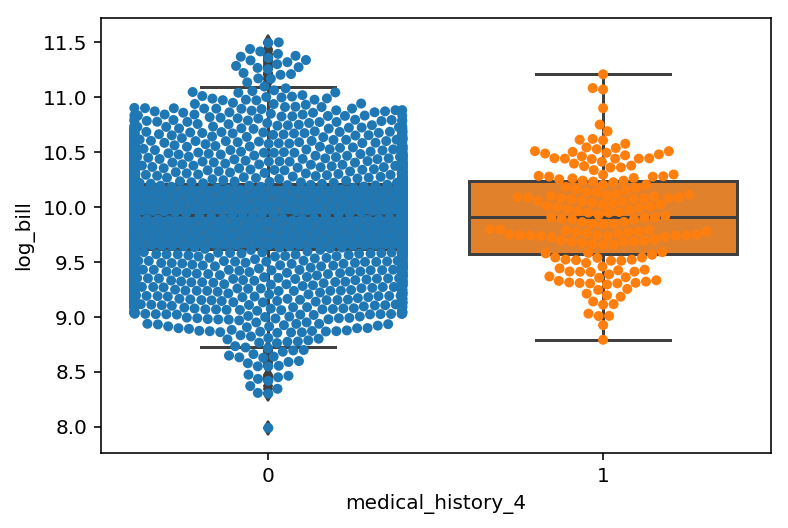

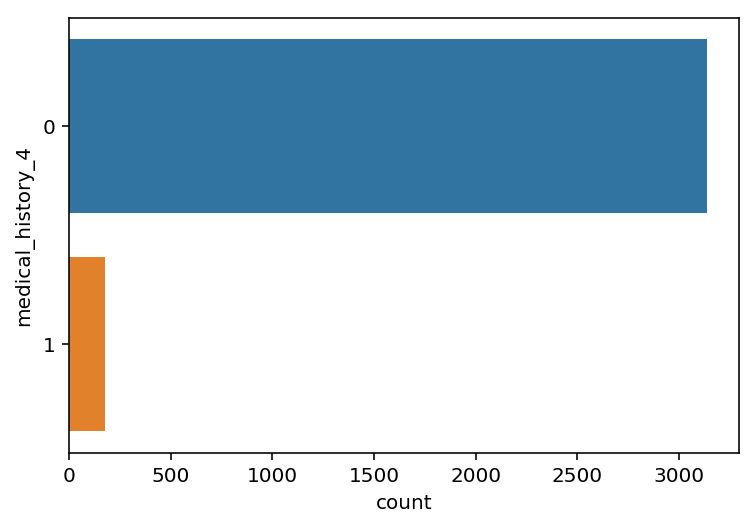


Value Count:
medical_history_4
0    2849
1     175
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_4
0    22430.861201
1    22345.453295
Name: tot_bill_yr, dtype: float64



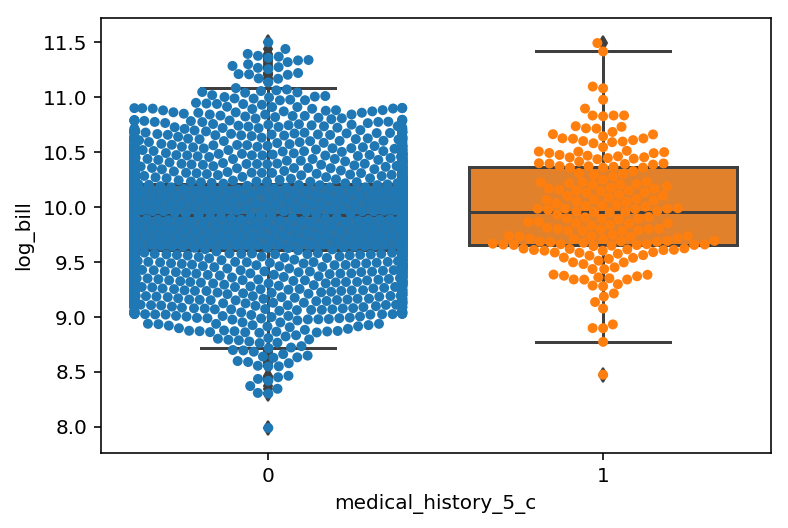

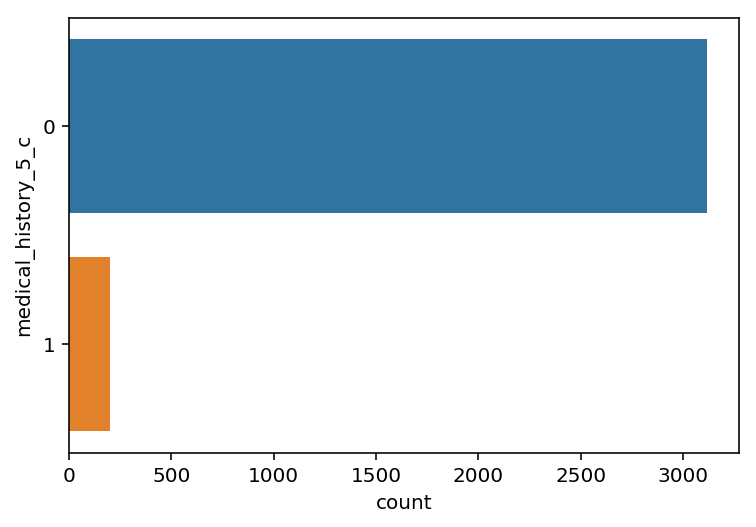


Value Count:
medical_history_5_c
0    2840
1     196
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_5_c
0    22286.469990
1    24627.281515
Name: tot_bill_yr, dtype: float64



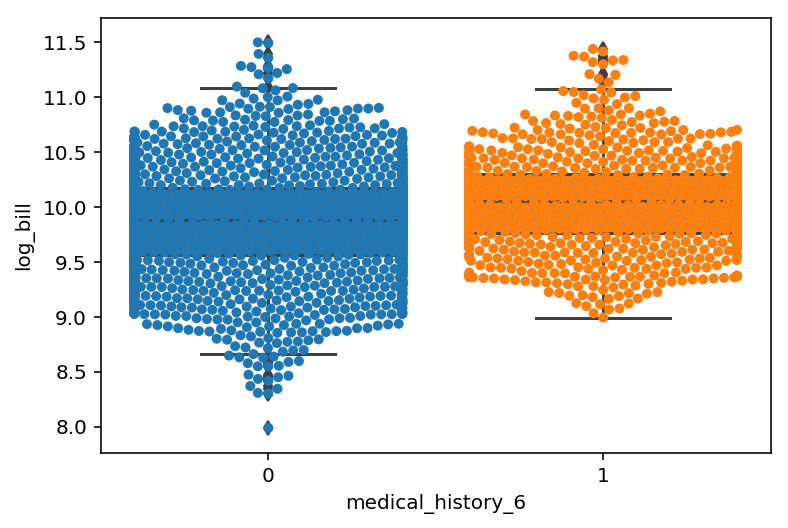

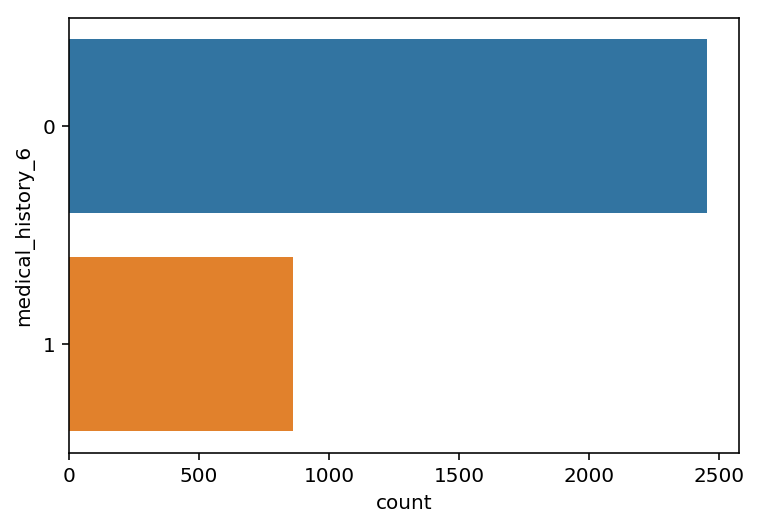


Value Count:
medical_history_6
0    2287
1     839
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    21368.208953
1    25445.648209
Name: tot_bill_yr, dtype: float64



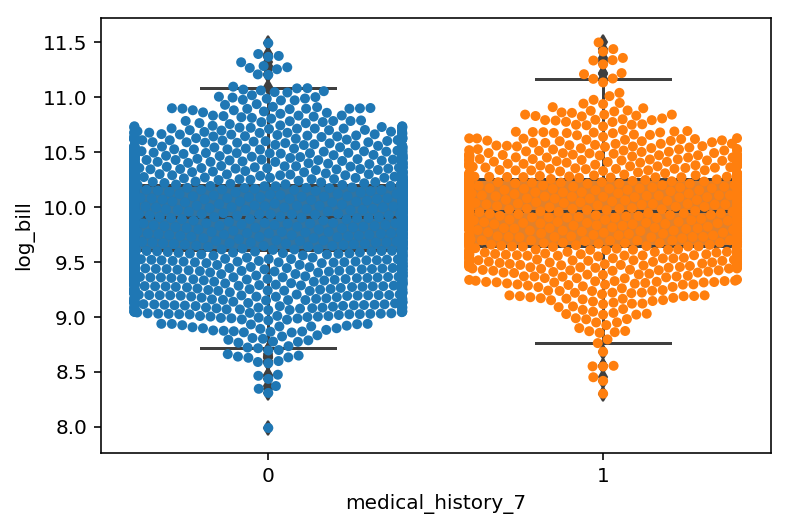

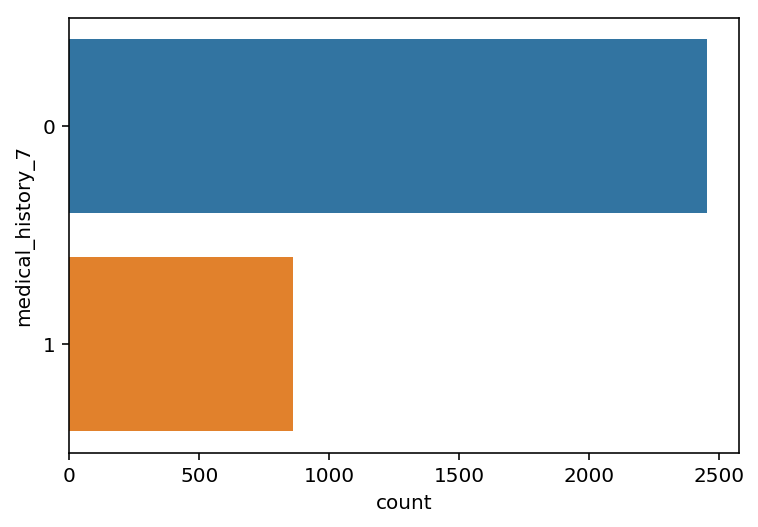


Value Count:
medical_history_7
0    2274
1     842
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    22035.299637
1    23540.362625
Name: tot_bill_yr, dtype: float64



In [11]:
# descriptive analysis for Medical History data

for c in hist_col: 
        sns.boxplot(y=df['log_bill'],x=df[c])
        sns.swarmplot(y=df['log_bill'],x=df[c])
        plt.show()
        sns.countplot(y = df[c])
        plt.show()
        print()
        print('Value Count:')
        print(df.groupby(c)['patient_id'].nunique())
        print()
        print('Mean Total Bills:')
        print(df.groupby(c)['tot_bill_yr'].mean())
        print()

In [12]:
# ONE WAY ANOVA for Medical Historys

for c in hist_col:

    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df[c] == 0]['log_bill'],df[df[c] == 1]['log_bill'])
    print('----------')
    print(c)
    print('----------')
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

----------
no_med_hist
----------
F: 24.047455183539782
P-value:  1.0111466926405764e-06
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
----------
medical_history_1
----------
F: 199.95797364026703
P-value:  3.9989767864015147e-44
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
----------
medical_history_2_c
----------
F: 7.311022107517914
P-value:  0.006888317284822007
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
----------
medical_history_3_c
----------
F: 5.182085228318565
P-value:  0.022884464968886086
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more

### Taking a deeper look into Number of Medical History, Medical History 1 and Medical History 6

** Number of medical history **

R:  0.23497714027118913
P-value:  8.329500865474938e-43


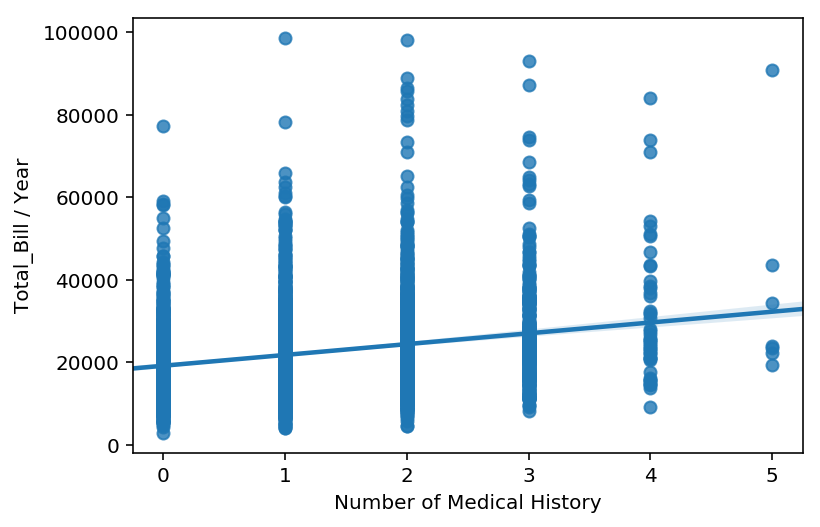

In [13]:
# Pearson Corrleation Coefficient on number of medical history
print ('R: ',stats.pearsonr(df['no_med_hist'], df['tot_bill_yr'])[0])
print ('P-value: ',stats.pearsonr(df['no_med_hist'], df['tot_bill_yr'])[1])

b = sns.regplot(df['no_med_hist'],df['tot_bill_yr'])
b.set_xlabel("Number of Medical History",fontsize=10)
b.set_ylabel("Total_Bill / Year",fontsize=10)
plt.show()

In [14]:
# ONE WAY ANOVA for Number of Medical History

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['no_med_hist'] == 0]['log_bill'],df[df['no_med_hist'] == 1]['log_bill'],df[df['no_med_hist'] == 2]['log_bill'],df[df['no_med_hist'] == 3]['log_bill'],df[df['no_med_hist'] == 4]['log_bill'],df[df['no_med_hist'] == 5]['log_bill'],)
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

F: 39.85699513970726
P-value:  6.63965452358468e-40
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


** Medical History 1, 2, 6 and 7 **

In [15]:
# Medical History 1

print(( df[df['medical_history_1'] == 1]['tot_bill_yr'].sum() / df['tot_bill_yr'].sum() ) * 100,'% of total bills came from patients with medical_history_1')

21.663134360311464 % of total bills came from patients with medical_history_1


In [16]:
# Medical History 2

print(( df[df['medical_history_2_c'] == 1]['tot_bill_yr'].sum() / df['tot_bill_yr'].sum() ) * 100,'% of total bills came from patients with medical_history_2')

30.88508772406575 % of total bills came from patients with medical_history_2


In [17]:
# Medical History 6

print(( df[df['medical_history_6'] == 1]['tot_bill_yr'].sum() / df['tot_bill_yr'].sum() ) * 100,'% of total bills came from patients with medical_history_6')

29.444307684617048 % of total bills came from patients with medical_history_6


In [18]:
# Medical History 7

print(( df[df['medical_history_7'] == 1]['tot_bill_yr'].sum() / df['tot_bill_yr'].sum() ) * 100,'% of total bills came from patients with medical_history_7')

27.271289737643222 % of total bills came from patients with medical_history_7


In [19]:
sns.set(rc={"figure.figsize": (15, 10)})

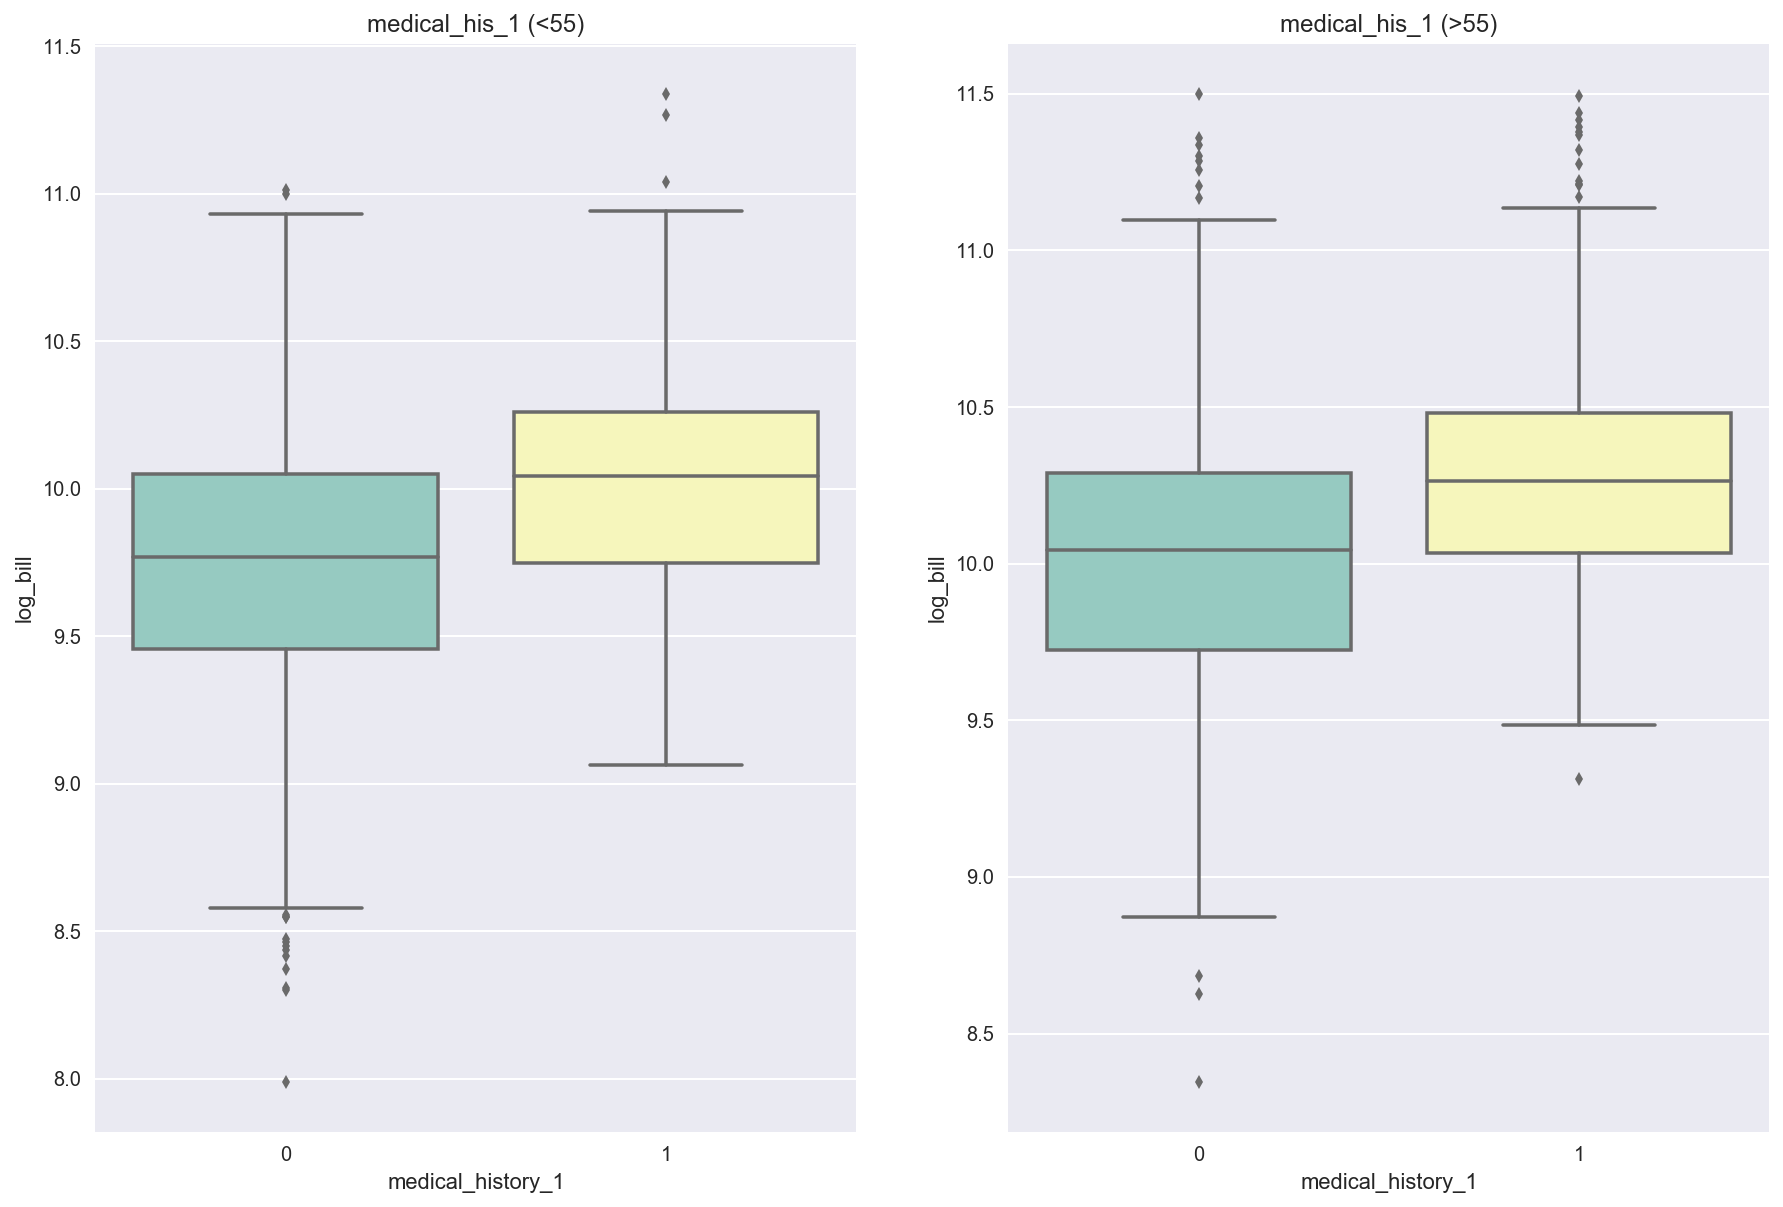


<55
Value Count:
medical_history_1
0    1503
1     302
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    18860.414427
1    24663.957922
Name: tot_bill_yr, dtype: float64

F: 116.37535603518349
P-value:  2.174786774170919e-26
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
medical_history_1
0    1026
1     260
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    24760.398909
1    31968.890489
Name: tot_bill_yr, dtype: float64

F: 79.21363426699983
P-value:  1.7226918860960684e-18
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


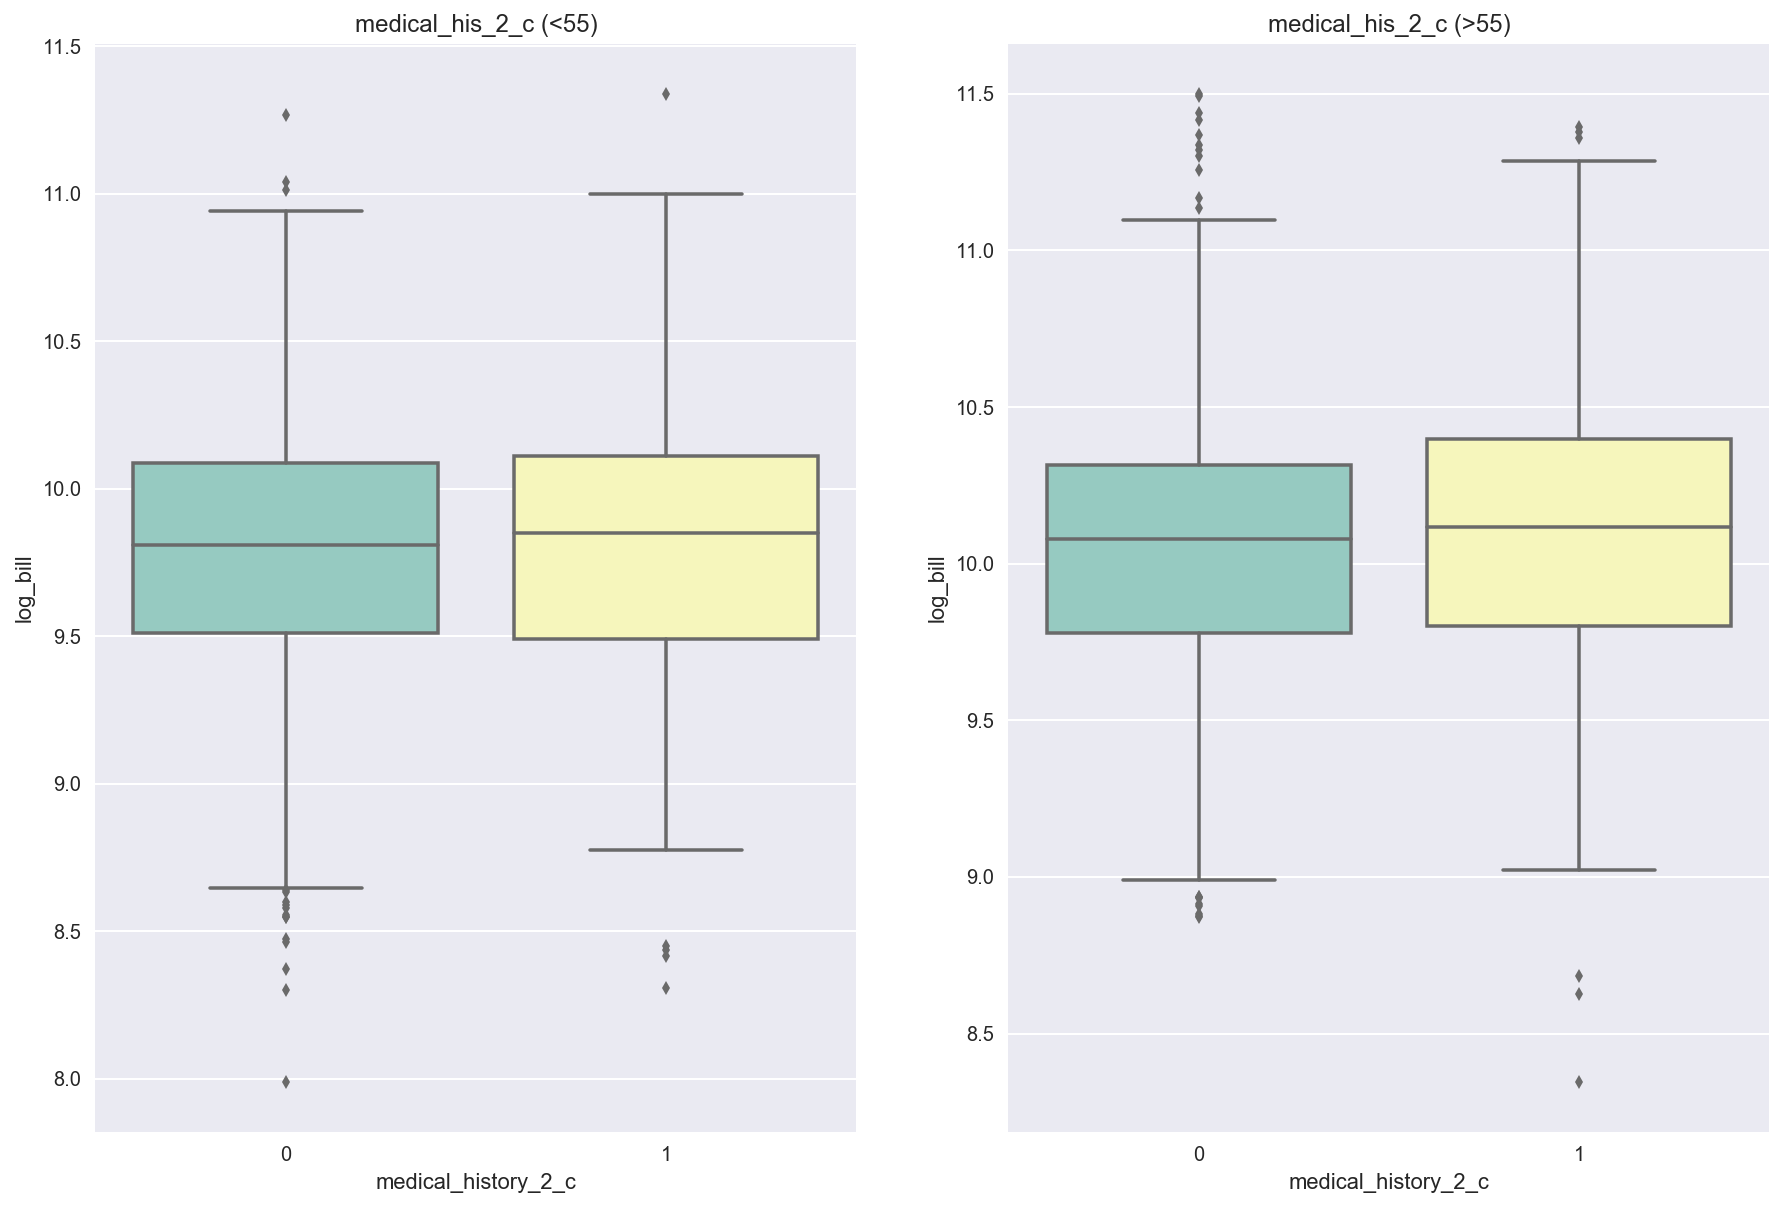


<55
Value Count:
medical_history_2_c
0    1297
1     537
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    19546.163733
1    20372.559928
Name: tot_bill_yr, dtype: float64

F: 2.370563359677592
P-value:  0.1238057591978006
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_2_c
0    882
1    417
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    25655.066674
1    27260.885794
Name: tot_bill_yr, dtype: float64

F: 3.224760132038215
P-value:  0.07275222816356448
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


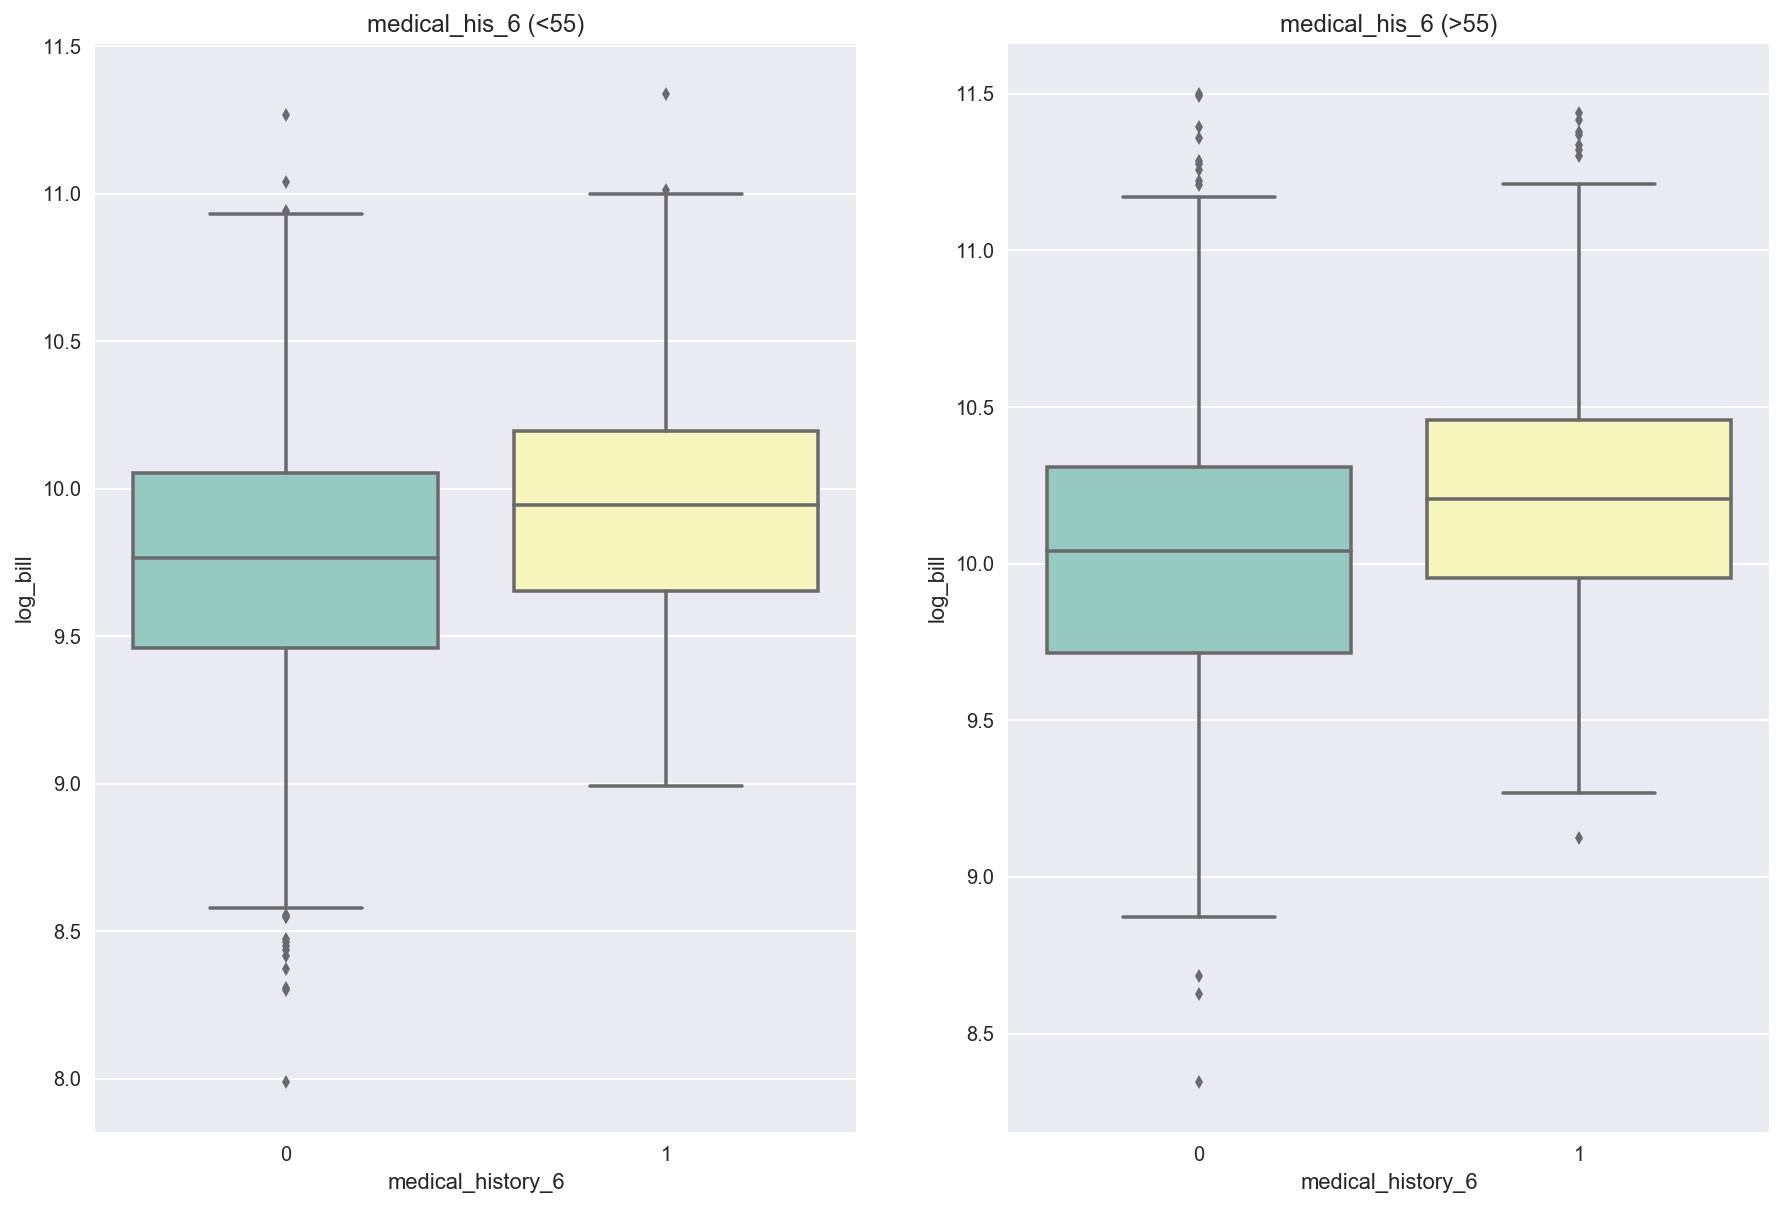


<55
Value Count:
medical_history_6
0    1327
1     506
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    18864.722843
1    22299.350985
Name: tot_bill_yr, dtype: float64

F: 68.26331791138054
P-value:  2.619391709344146e-16
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
medical_history_6
0    965
1    333
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    24812.017047
1    30211.092544
Name: tot_bill_yr, dtype: float64

F: 57.98547696347931
P-value:  4.8892590900494986e-14
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


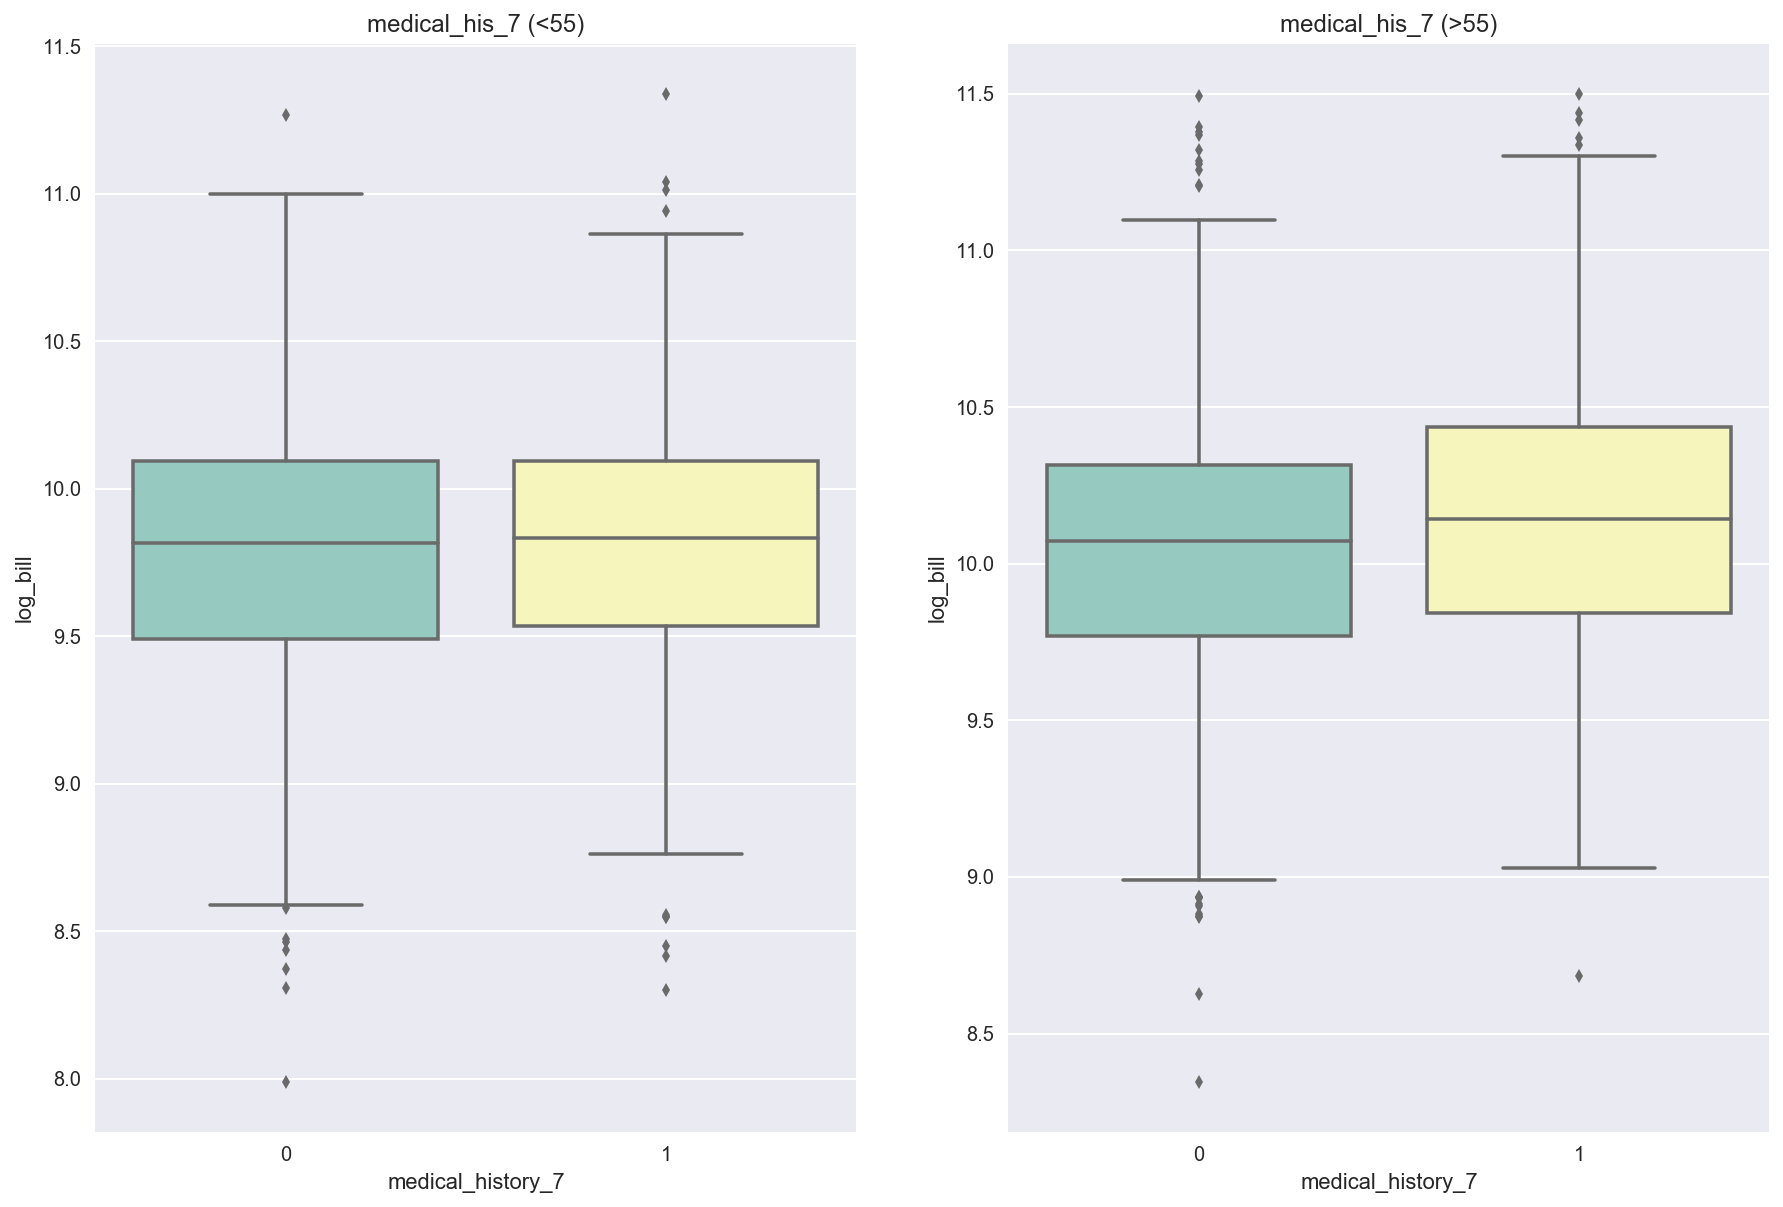


<55
Value Count:
medical_history_7
0    1331
1     496
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    19628.75196
1    20218.22705
Name: tot_bill_yr, dtype: float64

F: 1.0420109107239044
P-value:  0.307481721017316
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_7
0    950
1    346
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    25421.942787
1    28252.942584
Name: tot_bill_yr, dtype: float64

F: 12.527653840023946
P-value:  0.00041435805609508456
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


In [20]:
for x in ['1','2_c','6','7']:

    fig, ax =plt.subplots(1,2)

#     sns.boxplot(y=df[df['medical_history_'+x] == 1]['log_bill'],x=df[df['medical_history_'+x] == 1]['race_c'], palette="Set2",ax=ax[2]).set_title('medical_history_'+x)
    
    sns.boxplot(y=df[df['age_grp']==0]['log_bill'],x=df['medical_history_'+x], ax=ax[0],palette="Set3").set_title("medical_his_"+x+" (<55)")
#     sns.swarmplot(y=df[df['age_grp']==0]['log_bill'],x=df['medical_history_'+x], ax=ax[0])

    sns.boxplot(y=df[df['age_grp']==1]['log_bill'],x=df['medical_history_'+x], ax=ax[1],palette="Set3").set_title("medical_his_"+x+" (>55)")
#     sns.swarmplot(y=df[df['age_grp']==1]['log_bill'],x=df['medical_history_'+x], ax=ax[1])
    plt.show()

    print()
    print('<55')
    print('Value Count:')
    print(df[df['age_grp']==0].groupby('medical_history_'+x)['patient_id'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==0].groupby('medical_history_'+x)['tot_bill_yr'].mean())
    print()
    
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['medical_history_'+x] == 0]['log_bill'],df[df['age_grp']==0][df['medical_history_'+x] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')
    
    print()   
    print('##########################')    
    print('>55')
    print('Value Count:')
    print(df[df['age_grp']==1].groupby('medical_history_'+x)['patient_id'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==1].groupby('medical_history_'+x)['tot_bill_yr'].mean())
    print()
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['medical_history_'+x] == 0]['log_bill'],df[df['age_grp']==1][df['medical_history_'+x] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')
    

### BMI

mean bmi:  28.94840072420036


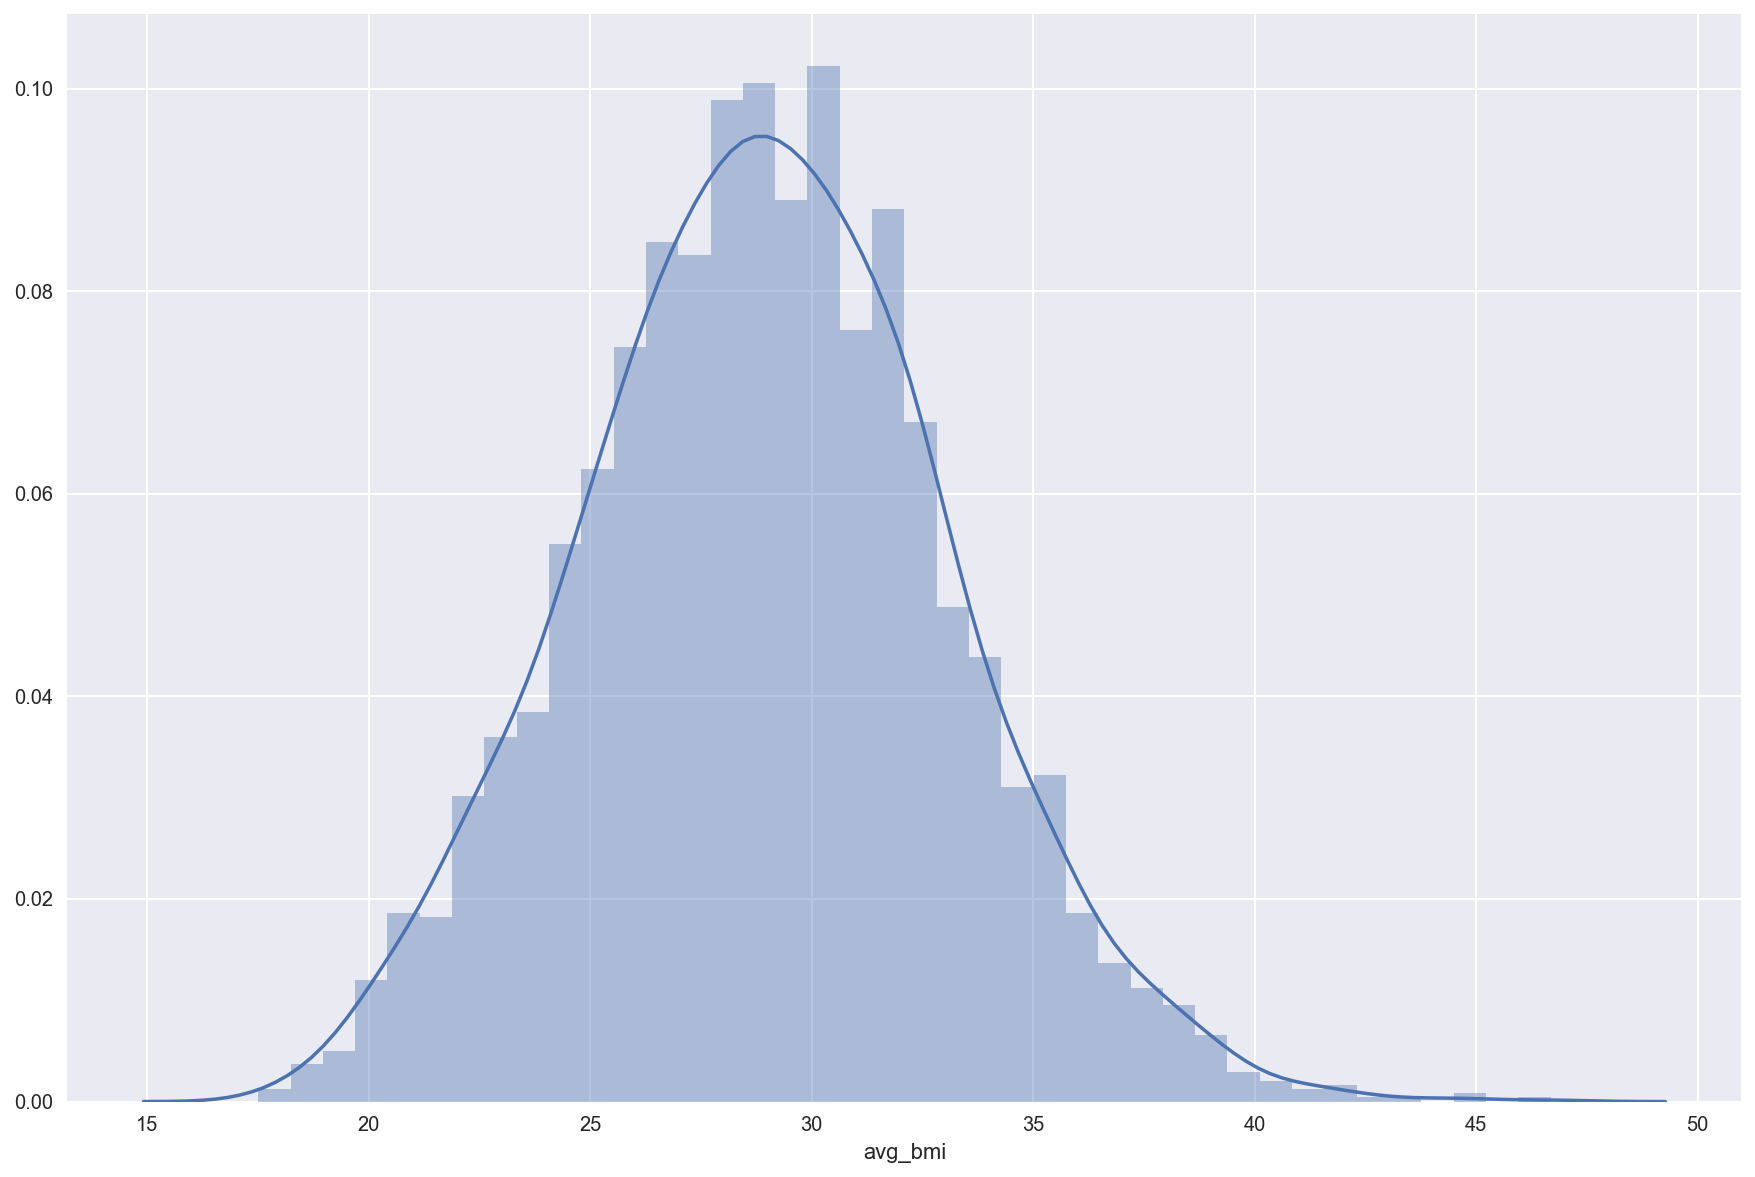

In [21]:
# distribution plot for bmi
print('mean bmi: ',np.mean(df['avg_bmi']))
sns.distplot(df['avg_bmi'])
plt.show()
print()

R:  0.13833432037127238
P-value:  1.254122426654186e-15


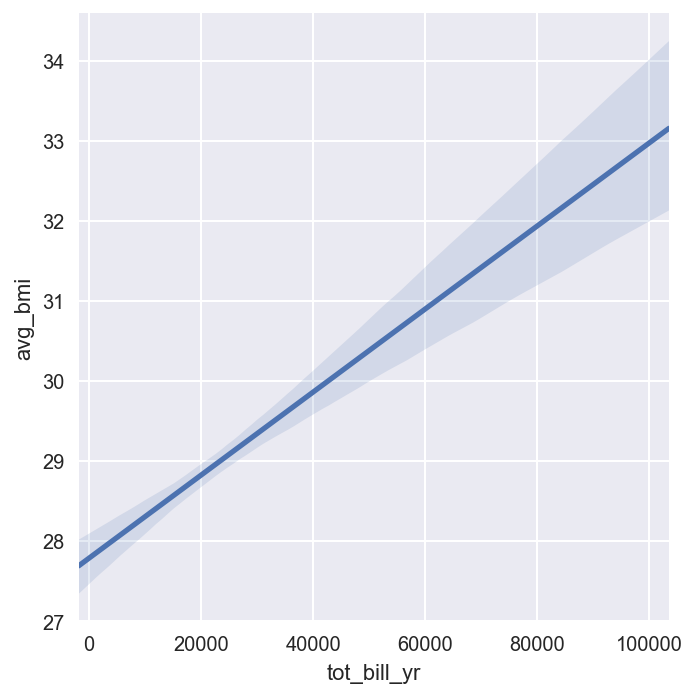

In [22]:
# Pearson Corrleation Coefficient on bmi
print ('R: ',stats.pearsonr(df['avg_bmi'], df['tot_bill_yr'])[0])
print ('P-value: ',stats.pearsonr(df['avg_bmi'], df['tot_bill_yr'])[1])

b = sns.lmplot(x='tot_bill_yr',y='avg_bmi',data=df,scatter=False)
plt.show()

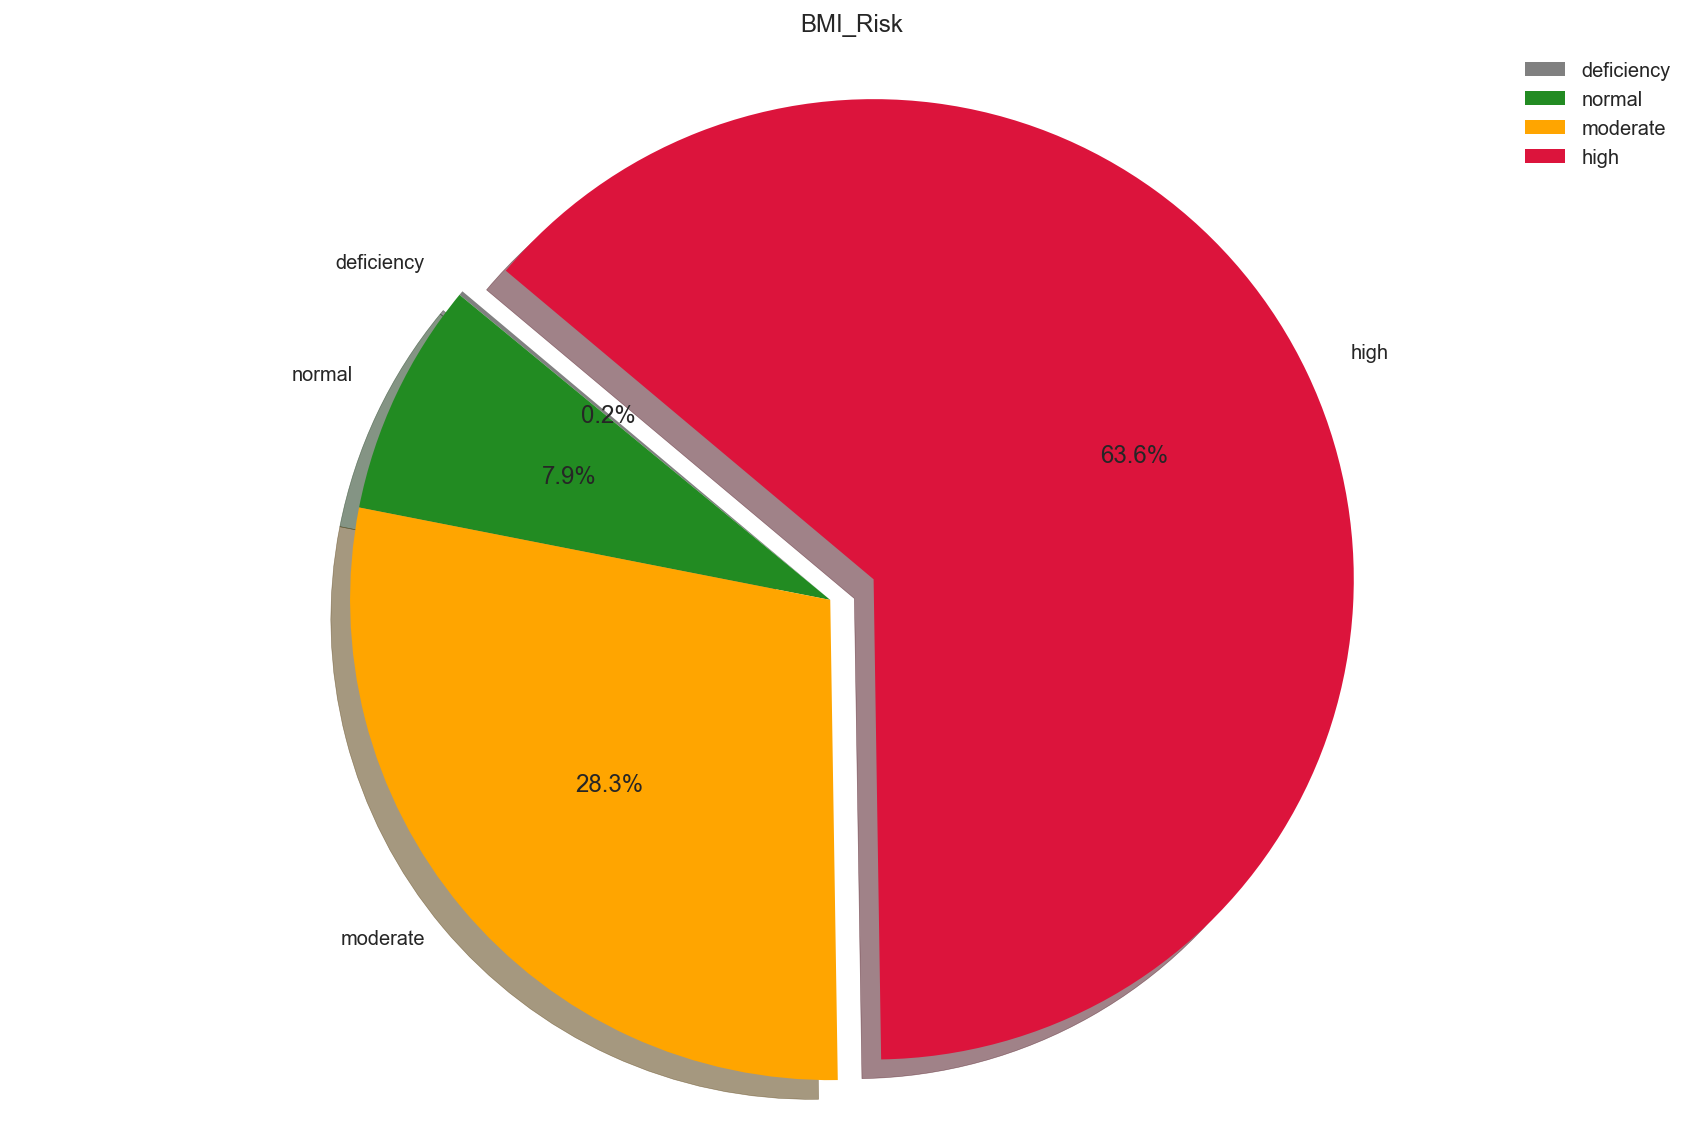

In [56]:
# sns.countplot(df['bmi_risk'])
# plt.show()

# Data to plot
labels = ['deficiency','normal','moderate','high']
sizes = [df[df['bmi_risk'] == 1]['patient_id'].count(),df[df['bmi_risk'] == 2]['patient_id'].count(),df[df['bmi_risk'] == 3]['patient_id'].count(),df[df['bmi_risk'] == 4]['patient_id'].count()]
colors = ['grey','forestgreen','orange','crimson']
explode = (0, 0,0,0.1)  # explode 1st slice

# colors=colors, explode=explode,                                                                                                        
                                                                                                       
# Plot
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)
 
plt.axis('equal')
plt.legend()
plt.title('BMI_Risk')

plt.show()

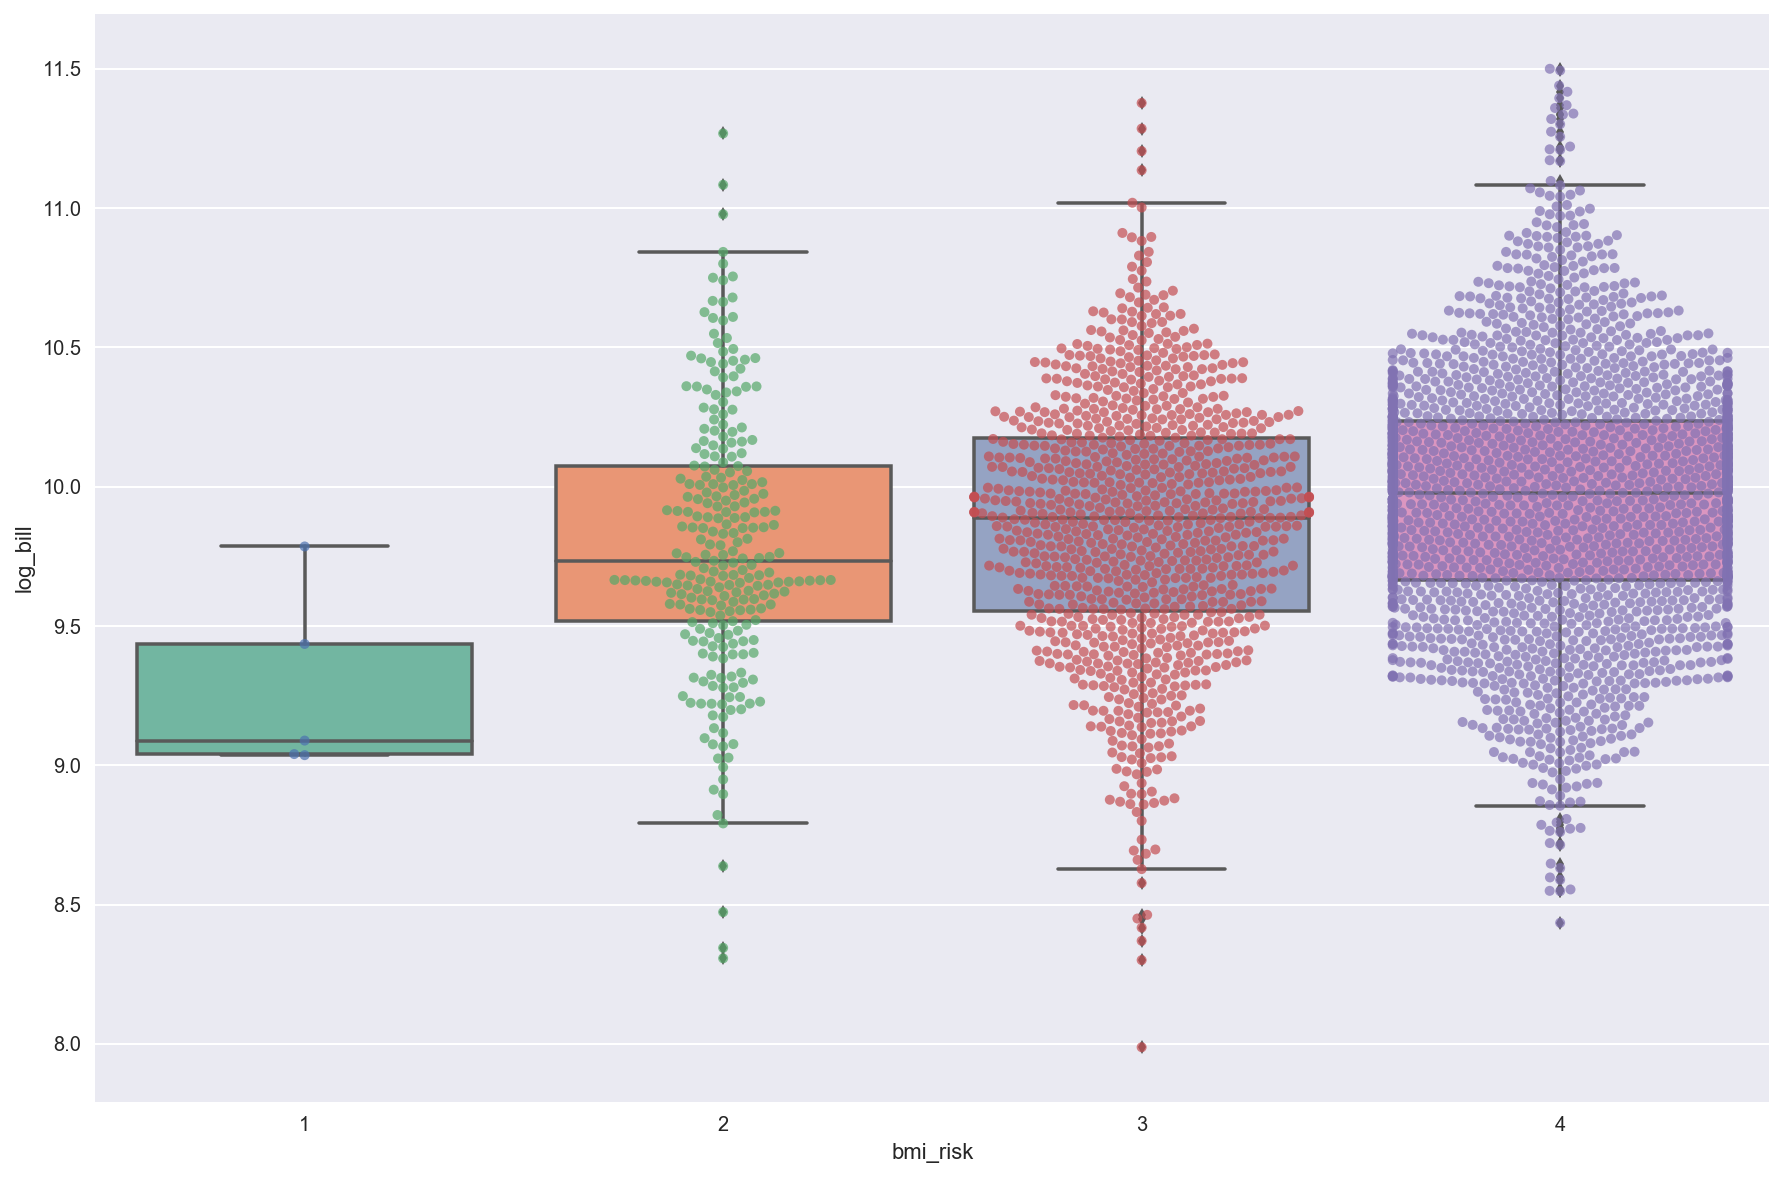

In [24]:
sns.boxplot(y=df['log_bill'],x=df['bmi_risk'],palette="Set2")
sns.swarmplot(y=df['log_bill'],x=df['bmi_risk'],alpha=0.7)

plt.show()

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.5136 0.0622 -0.0172 1.0443  False
     1      3   0.5808 0.0241  0.0537  1.108   True
     1      4   0.6751 0.0055  0.1487 1.2014   True
     2      3   0.0673 0.1529  -0.015 0.1495  False
     2      4   0.1615  0.001  0.0844 0.2387   True
     3      4   0.0943  0.001  0.0481 0.1404   True
---------------------------------------------------


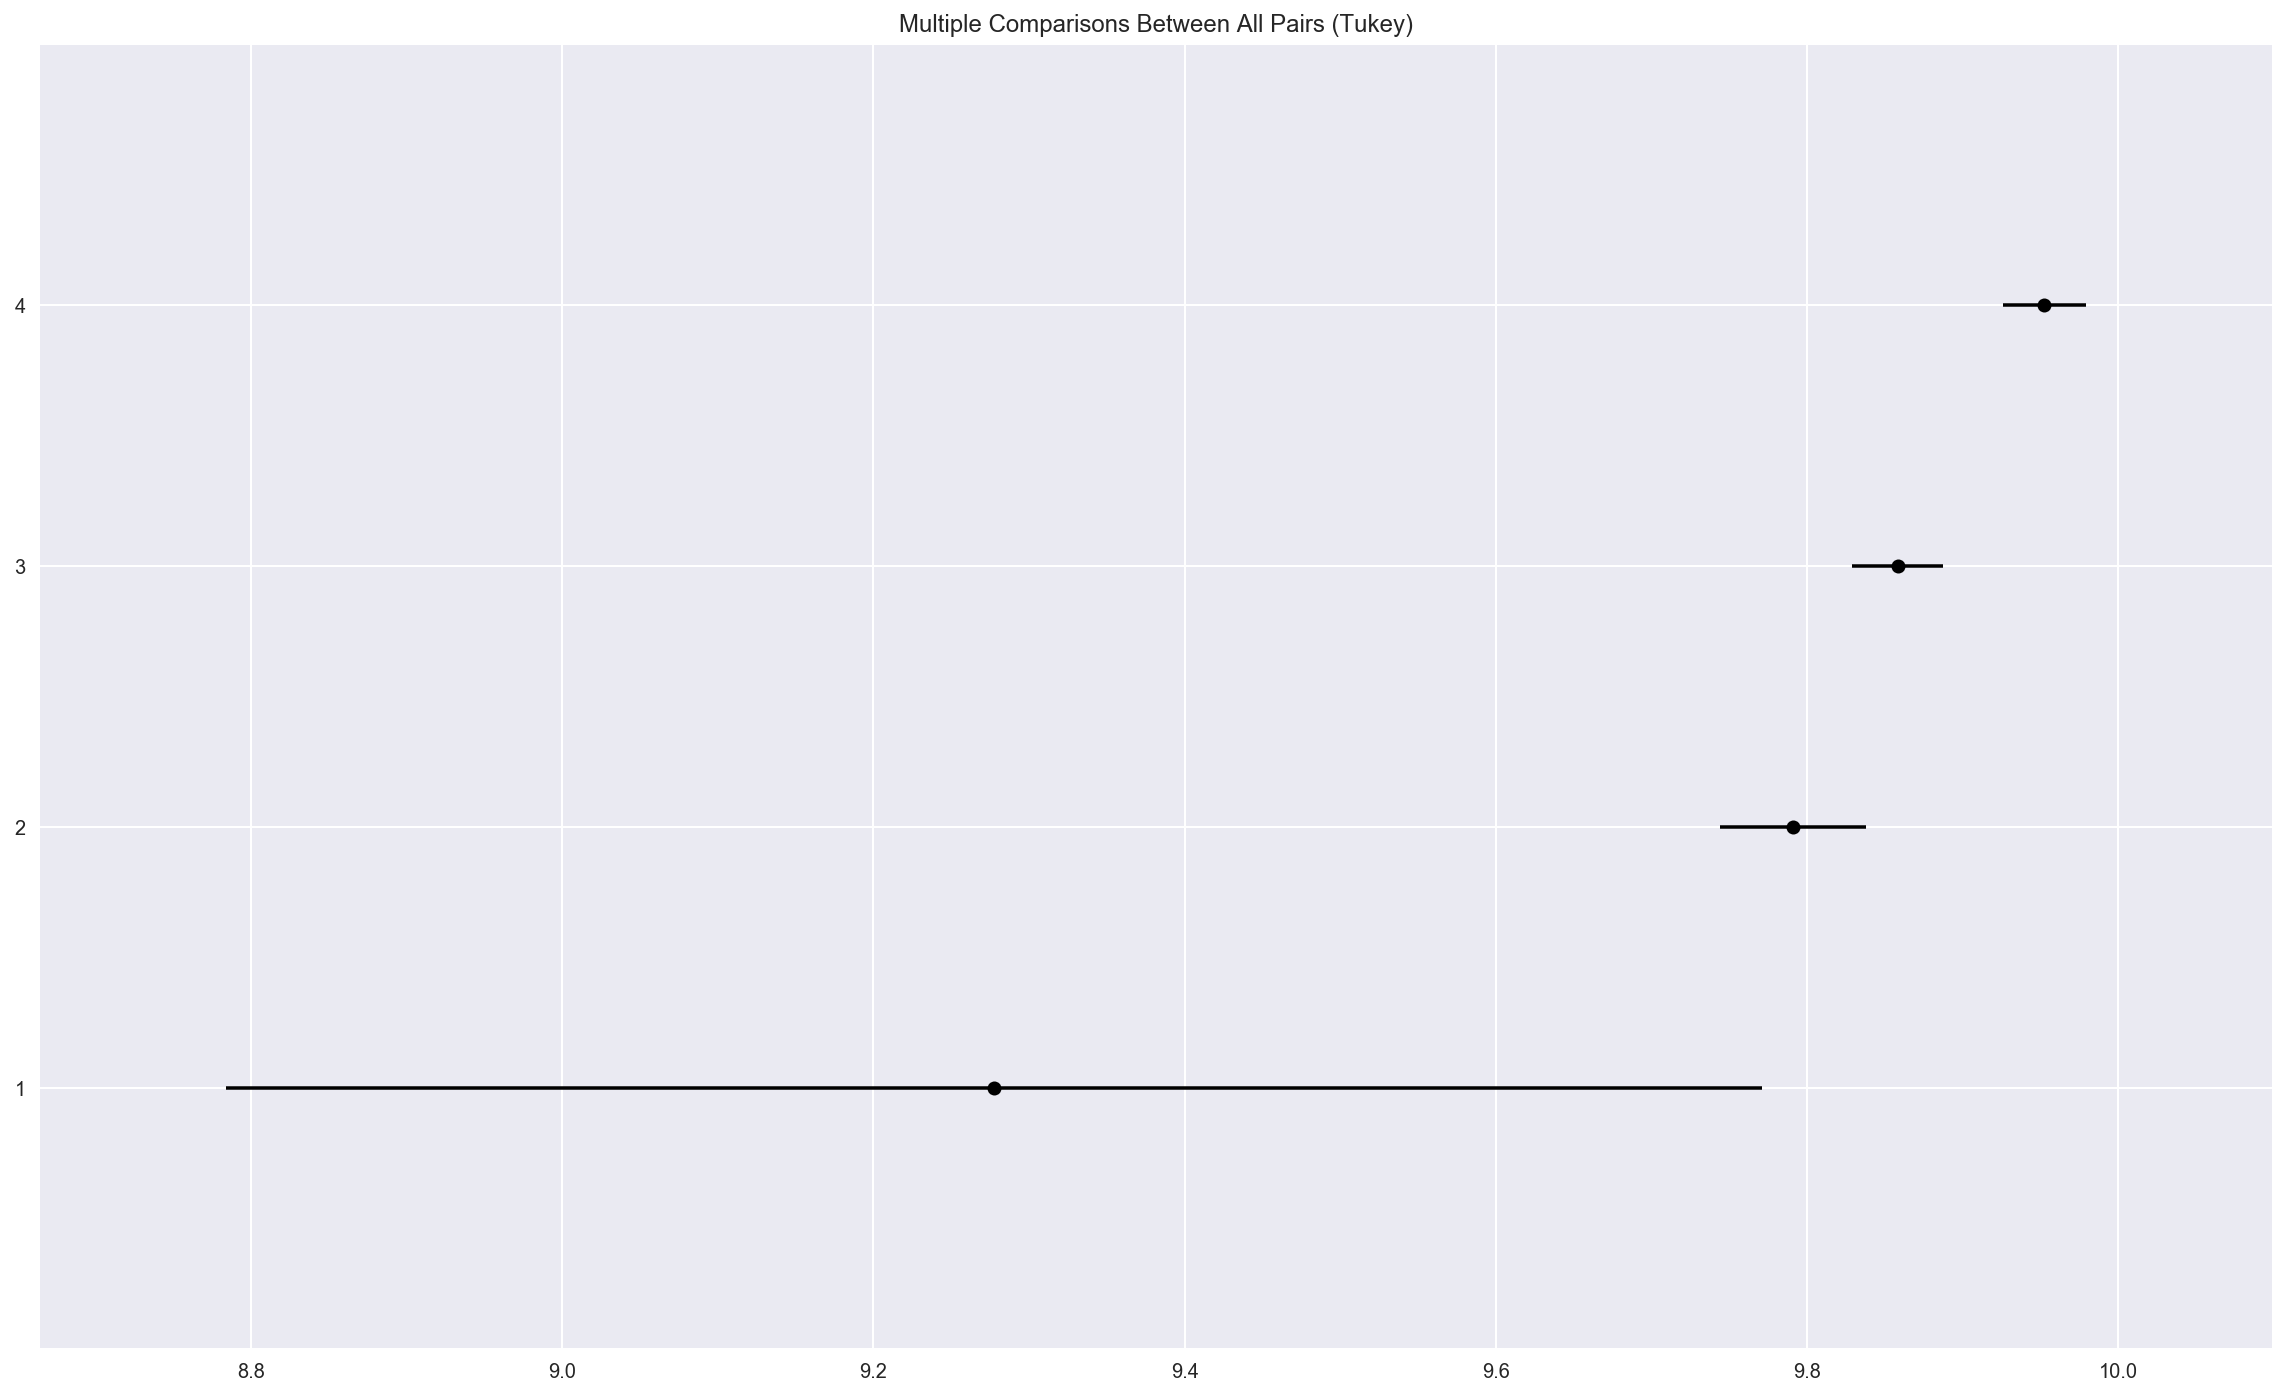

In [25]:
def tukey_hsd(df,col,aspect='log_bill'):

    # DataFrame.
    tukeyhsd = multi.pairwise_tukeyhsd(df[aspect].values,df[col].values, alpha=0.05)
    result = tukeyhsd.summary()
    print(result)

    #visualisation
    tukeyhsd.plot_simultaneous(figsize=(20,12))
    
tukey_hsd(df,'bmi_risk')

In [59]:
print()   
print('##########################')    
print('Value Count:')
print(df.groupby('bmi_risk')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df.groupby('bmi_risk')['tot_bill_yr'].mean())
print()

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['bmi_risk'] == 1]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 2]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 3]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 4]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['bmi_risk'] == 1]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 2]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 3]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 4]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')



##########################
Value Count:
bmi_risk
1       5
2     240
3     870
4    1917
Name: patient_id, dtype: int64

Mean Total Bills:
bmi_risk
1    11200.494000
2    20013.527280
3    21157.032812
4    23316.669194
Name: tot_bill_yr, dtype: float64

F: 10.44587740719324
P-value:  8.119399706052805e-07
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
F: 12.474585821466837
P-value:  4.748199185650617e-08
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Linear Regression Model

Y = β0 + β1 medical history 1 + β2 medical history 6 + β3 medical history 7 +  β4 high bmi + β5 age > 55 + β6 foreigner + β7 malay + β8 indian

In [73]:
# Variance Inflation Factor to check for multicolinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

#gather features
features = "+".join(X.columns)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round()

,VIF Factor,features
0,1.0,medical_history_1
1,1.0,medical_history_6
2,1.0,medical_history_7
3,2.0,bmi_high
4,1.0,age_grp
5,1.0,foreigner
6,1.0,malay
7,1.0,indian


In [100]:
# Using Statsmodel

X = df[['medical_history_1','medical_history_6','medical_history_7','bmi_high','age_grp','foreigner','malay']].to_numpy()
y = df['log_bill'].to_numpy()

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     320.7
Date:                Mon, 20 Sep 2021   Prob (F-statistic):               0.00
Time:                        02:01:10   Log-Likelihood:                -1277.9
No. Observations:                3314   AIC:                             2572.
Df Residuals:                    3306   BIC:                             2621.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5100      0.013    710.891      0.0

In [116]:
import math

print ('Average total bill per year for patients with condition X and medical history 1 is ~', round ((math.exp(est2.params[1]) - 1) * 100,2),'% higher when compared to patients without' )
print ('Average total bill per year for patients with condition X and medical history 6 is ~', round ((math.exp(est2.params[2]) - 1) * 100,2),'% higher when compared to patients without' )
print ('Average total bill per year for patients with condition X and medical history 7 is ~', round ((math.exp(est2.params[3]) - 1) * 100,2),'% higher when compared to patients without' )
print ("Average total bill per year for patients with condition X and high bmi is ~", round ((math.exp(est2.params[4]) - 1) * 100,2),"% higher when compared to patients doesn't" )
print ('Average total bill per year for patients with condition X > 55 years old is ~', round ((math.exp(est2.params[5]) - 1) * 100,2),'% higher when compared to patients < 55' )
print ('Average total bill per year for foreigner patients with condition X is ~', round ((math.exp(est2.params[6]) - 1) * 100,2),'% higher when compared to patients who are Singaporeans or PR' )
print ('Average total bill per year for malay patients with condition X is ~', round ((math.exp(est2.params[7]) - 1) * 100,2),'% higher when compared to patients of other races' )
# print ('Average total bill per year for indian patients with condition X is ~', round ((math.exp(est2.params[8]) - 1) * 100,2),'% higher when compared to patients of other races' )

# https://stats.idre.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/

Average total bill per year for patients with condition X and medical history 1 is ~ 31.03 % higher when compared to patients without
Average total bill per year for patients with condition X and medical history 6 is ~ 22.05 % higher when compared to patients without
Average total bill per year for patients with condition X and medical history 7 is ~ 5.49 % higher when compared to patients without
Average total bill per year for patients with condition X and high bmi is ~ 11.76 % higher when compared to patients doesn't
Average total bill per year for patients with condition X > 55 years old is ~ 28.45 % higher when compared to patients < 55
Average total bill per year for foreigner patients with condition X is ~ 96.42 % higher when compared to patients who are Singaporeans or PR
Average total bill per year for malay patients with condition X is ~ 48.88 % higher when compared to patients of other races


# Decision Tree Model

In [111]:
X = df[['medical_history_1','medical_history_6','medical_history_7','bmi_high','age_grp','foreigner','malay']]
y = df['tot_bill_yr']

regr = DecisionTreeRegressor(random_state=222,max_depth=7)
regr.fit(X,y)

print ('R2 Score: ', regr.score(X,y) )

impt = pd.DataFrame(index=X.columns)
impt['impt'] = regr.feature_importances_
impt = impt.sort_values('impt',ascending=False)

R2 Score:  0.5279361722458931


In [112]:
impt

,impt
foreigner,0.321402
malay,0.266404
age_grp,0.148774
medical_history_1,0.099145
medical_history_6,0.080637
bmi_high,0.045383
medical_history_7,0.038256


In [113]:
import graphviz
dot_data = tree.export_graphviz(regr, out_file=None, 
                                feature_names=X.columns,  
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 

In [114]:
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

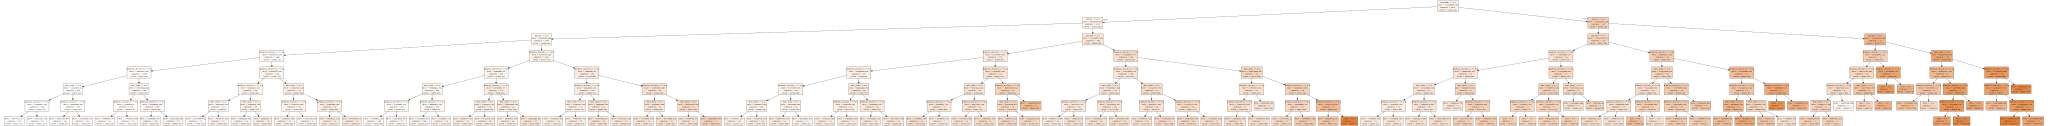

In [115]:
graph